# Bike Sharing Classification

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

### Preprocessing

In [2]:
bike_df = pd.read_csv('../data/SeoulBikeData.csv', engine = 'python')

bike_df.columns = ['date', 'bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
                   'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

bike_df['date'] = pd.to_datetime(bike_df['date'], format = '%d/%m/%Y')
bike_df['hour'] = bike_df['hour'].astype('category')
bike_df['season'] = bike_df['season'].astype('category')
bike_df['holiday'] = bike_df['holiday'].astype('category')
bike_df['functioning_day'] = bike_df['functioning_day'].astype('category')
bike_df['day'] = bike_df['date'].dt.day_name().astype('category')

bike_df = bike_df[bike_df['functioning_day'] == 'Yes']
bike_df = bike_df.drop(['date', 'functioning_day', 'dew_point_temp'], axis = 1)
bike_df = bike_df.reset_index(drop = True)

bike_df.head()

,bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,season,holiday,day
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Friday


In [3]:
full_df = bike_df

full_ddf = pd.get_dummies(full_df['hour'], drop_first = True, prefix = 'hour:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['day'], drop_first = True, prefix = 'day:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['season'], drop_first = True, prefix = 'season:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['holiday'],  prefix = 'holiday:')], axis = 1)
full_ddf = full_ddf.drop('holiday:_No Holiday', axis = 1)

full_df = full_df.drop(['hour', 'day', 'season', 'holiday'], axis = 1)

y = pd.DataFrame(full_df['bike_count']).reset_index(drop = True)
c = y > np.median(y)

full_df = full_df.drop('bike_count', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [4]:
random.seed(42)
X_train = X.sample(frac = 0.7).sort_index()
c_train = c[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
c_test = c[~X.index.isin(X_train.index)]

### k-NN Classification

In [5]:
knnc_k_arr = list(range(1, 21))

knnc = GridSearchCV(KNeighborsClassifier(), 
                    param_grid = {'n_neighbors' : knnc_k_arr}, 
                    cv = 5, return_train_score = True)

knnc.fit(X_train.values, c_train.values.ravel())

knnc_df = pd.DataFrame(knnc.cv_results_)

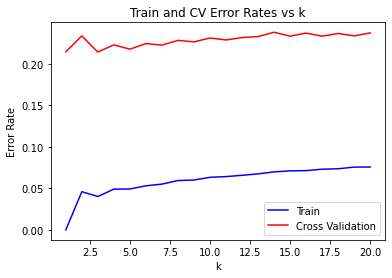

In [6]:
plt.plot(knnc_df['param_n_neighbors'], 1 - knnc_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(knnc_df['param_n_neighbors'], 1 - knnc_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.legend(loc = 4)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train and CV Error Rates vs k')
plt.show()

Best Parameters: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.79


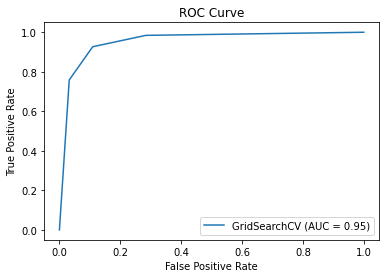

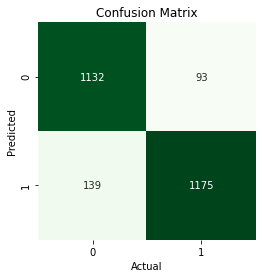

Accuracy: 0.91
Senstivity: 0.93
Specificity: 0.89


In [7]:
print('Best Parameters: {}'.format(knnc.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(knnc.best_score_))

pred_knnc = knnc.predict(X_test)

plot_roc_curve(knnc, X_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_knnc = confusion_matrix(c_test, pred_knnc)
tn, fp, fn, tp = cm_knnc.ravel()

ax = sns.heatmap(cm_knnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_knnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### ANN Classification

#### Model 1: Hyperparameters: Batch size and # of Epochs

In [8]:
def create_model1():
    model = Sequential()
    model.add(Input(shape = (40, )))
    model.add(Dense(10, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
    return model

In [9]:
nnc1_model = KerasClassifier(build_fn = create_model1, verbose = 0)

nnc1_batch_size_arr = [10, 20, 50]
nnc1_epoch_arr = [10, 50, 100]

nnc1 = GridSearchCV(estimator = nnc1_model, 
                    param_grid = {'batch_size' : nnc1_batch_size_arr, 
                                  'epochs' : nnc1_epoch_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc1.fit(X_train.values, c_train.values.ravel())

nnc1_df = pd.DataFrame(nnc1.cv_results_)

Best Parameters: {'batch_size': 10, 'epochs': 100}
Best Cross-Validation Accuracy: 0.88
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


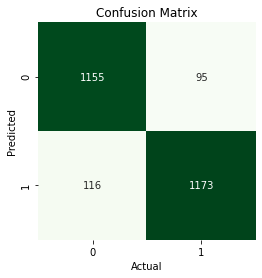

Accuracy: 0.92
Senstivity: 0.93
Specificity: 0.91


In [10]:
print('Best Parameters: {}'.format(nnc1.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc1.best_score_))

pred_nnc1 = nnc1.predict(X_test)

# plot_roc_curve(nnc1, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc1 = confusion_matrix(c_test, pred_nnc1)
tn, fp, fn, tp = cm_nnc1.ravel()

ax = sns.heatmap(cm_nnc1.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc1)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 2: Activation Function of the 1st hidden layer nodes

In [11]:
def create_model2(activation = 'sigmoid'):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(10, activation = activation))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
    return model

In [12]:
nnc2_model = KerasClassifier(build_fn = create_model2, batch_size = 10, epochs = 100, verbose = 0)

nnc2_activation_arr = ['linear', 'relu', 'sigmoid', 'tanh']

nnc2 = GridSearchCV(estimator = nnc2_model, 
                    param_grid = {'activation' : nnc2_activation_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc2.fit(X_train.values, c_train.values.ravel())

nnc2_df = pd.DataFrame(nnc2.cv_results_)

In [13]:
nnc2_df[['param_activation', 'mean_train_score', 'mean_test_score']]

,param_activation,mean_train_score,mean_test_score
0,linear,0.915499,0.885745
1,relu,0.946971,0.898235
2,sigmoid,0.918072,0.878150
3,tanh,0.941908,0.890471


Best Parameters: {'activation': 'relu'}
Best Cross-Validation Accuracy: 0.90


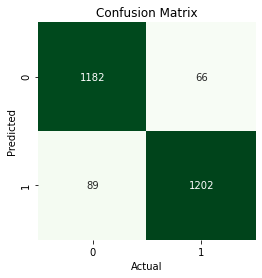

Accuracy: 0.94
Senstivity: 0.95
Specificity: 0.93


In [14]:
print('Best Parameters: {}'.format(nnc2.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc2.best_score_))

pred_nnc2 = nnc2.predict(X_test)

# plot_roc_curve(nnc2, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc2 = confusion_matrix(c_test, pred_nnc2)
tn, fp, fn, tp = cm_nnc2.ravel()

ax = sns.heatmap(cm_nnc2.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc2)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 3: Learning Rate and Momentum of the 1st hidden layer nodes

In [15]:
def create_model3(learn_rate = 0.01, momentum = 0.0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = learn_rate, momentum = momentum)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [16]:
nnc3_model = KerasClassifier(build_fn = create_model3, batch_size = 10, epochs = 100, verbose = 0)

nnc3_learn_rate_arr = [0.001, 0.01, 0.1, 0.2, 0.5]
nnc3_momentum_arr = [0.0, 0.1, 0.2, 0.5, 0.9]

nnc3 = GridSearchCV(estimator = nnc3_model, 
                    param_grid = {'learn_rate' : nnc3_learn_rate_arr,
                                  'momentum' : nnc3_momentum_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc3.fit(X_train.values, c_train.values.ravel())

nnc3_df = pd.DataFrame(nnc3.cv_results_)

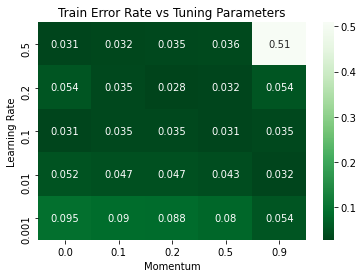

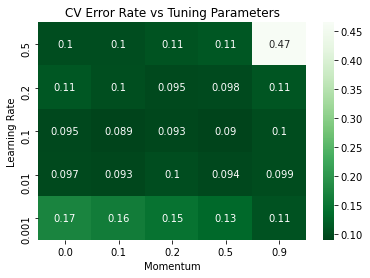

In [17]:
nnc3_train_err_mat = (1 - nnc3_df['mean_train_score']).values.reshape(len(nnc3_learn_rate_arr), len(nnc3_momentum_arr))
ax = sns.heatmap(pd.DataFrame(nnc3_train_err_mat, columns = nnc3_momentum_arr, index = nnc3_learn_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Momentum', ylabel = 'Learning Rate', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

nnc3_cv_err_mat = (1 - nnc3_df['mean_test_score']).values.reshape(len(nnc3_learn_rate_arr), len(nnc3_momentum_arr))
ax = sns.heatmap(pd.DataFrame(nnc3_cv_err_mat, columns = nnc3_momentum_arr, index = nnc3_learn_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Momentum', ylabel = 'Learning Rate', title = 'CV Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {'learn_rate': 0.1, 'momentum': 0.1}
Best Cross-Validation Accuracy: 0.91


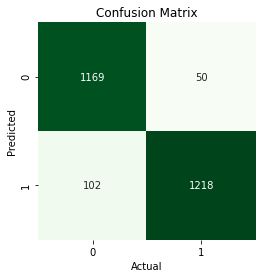

Accuracy: 0.94
Senstivity: 0.96
Specificity: 0.92


In [18]:
print('Best Parameters: {}'.format(nnc3.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc3.best_score_))

pred_nnc3 = nnc3.predict(X_test)

# plot_roc_curve(nnc3, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc3 = confusion_matrix(c_test, pred_nnc3)
tn, fp, fn, tp = cm_nnc3.ravel()

ax = sns.heatmap(cm_nnc3.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc3)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 4: Drop-out Rate and Weight Constraint of the 1st hidden layer nodes

In [19]:
def create_model4(dropout_rate = 0.0, weight_constraint = 0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(10, activation = 'relu', kernel_constraint = maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

In [20]:
nnc4_model = KerasClassifier(build_fn = create_model4, batch_size = 10, epochs = 100, verbose = 0)

nnc4_wgt_constraint_arr = [0, 1, 2, 3, 4, 5]
nnc4_dropout_rate_arr = [0.0, 0.1, 0.2, 0.5, 0.9]

nnc4 = GridSearchCV(estimator = nnc4_model, 
                    param_grid = {'weight_constraint' : nnc4_wgt_constraint_arr,
                                  'dropout_rate' : nnc4_dropout_rate_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc4.fit(X_train.values, c_train.values.ravel())

nnc4_df = pd.DataFrame(nnc4.cv_results_)

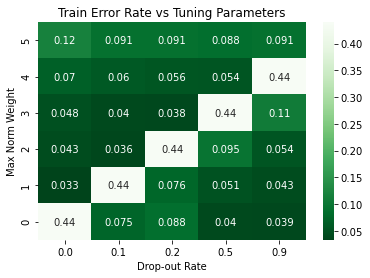

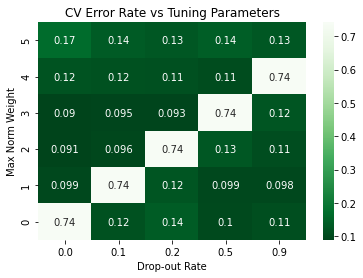

In [21]:
nnc4_train_err_mat = (1 - nnc4_df['mean_train_score']).values.reshape(len(nnc4_wgt_constraint_arr), 
                                                                      len(nnc4_dropout_rate_arr))
ax = sns.heatmap(pd.DataFrame(nnc4_train_err_mat, columns = nnc4_dropout_rate_arr, 
                              index = nnc4_wgt_constraint_arr).iloc[::-1], annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Drop-out Rate', ylabel = 'Max Norm Weight', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

nnc4_cv_err_mat = (1 - nnc4_df['mean_test_score']).values.reshape(len(nnc4_wgt_constraint_arr), len(nnc4_dropout_rate_arr))
ax = sns.heatmap(pd.DataFrame(nnc4_cv_err_mat, columns = nnc4_dropout_rate_arr, 
                              index = nnc4_wgt_constraint_arr).iloc[::-1], annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Drop-out Rate', ylabel = 'Max Norm Weight', title = 'CV Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {'dropout_rate': 0.2, 'weight_constraint': 3}
Best Cross-Validation Accuracy: 0.91


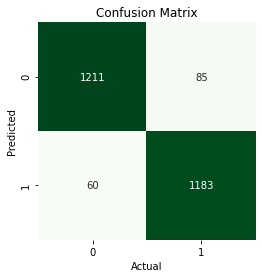

Accuracy: 0.94
Senstivity: 0.93
Specificity: 0.95


In [22]:
print('Best Parameters: {}'.format(nnc4.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc4.best_score_))

pred_nnc4 = nnc4.predict(X_test)

# plot_roc_curve(nnc4, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc4 = confusion_matrix(c_test, pred_nnc4)
tn, fp, fn, tp = cm_nnc4.ravel()

ax = sns.heatmap(cm_nnc4.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc4)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 5: # of Neurons in the 1st hidden layer

In [23]:
def create_model5(neurons = 0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

In [24]:
nnc5_model = KerasClassifier(build_fn = create_model5, batch_size = 10, epochs = 100, verbose = 0)

nnc5_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc5 = GridSearchCV(estimator = nnc5_model, 
                    param_grid = {'neurons' : nnc5_neuron_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc5.fit(X_train.values, c_train.values.ravel())

nnc5_df = pd.DataFrame(nnc5.cv_results_)

In [25]:
nnc5_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,0.897823,0.821948
1,5,0.928451,0.877642
2,10,0.950261,0.888952
3,15,0.959416,0.911229
4,20,0.965111,0.905998
5,25,0.968908,0.908023
6,30,0.973464,0.899414


Best Parameters: {'neurons': 15}
Best Cross-Validation Accuracy: 0.91


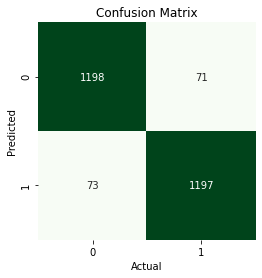

Accuracy: 0.94
Senstivity: 0.94
Specificity: 0.94


In [26]:
print('Best Parameters: {}'.format(nnc5.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc5.best_score_))

pred_nnc5 = nnc5.predict(X_test)

# plot_roc_curve(nnc5, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc5 = confusion_matrix(c_test, pred_nnc5)
tn, fp, fn, tp = cm_nnc5.ravel()

ax = sns.heatmap(cm_nnc5.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc5)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 6: # of Neurons in the 2nd hidden layer

In [27]:
def create_model6(neurons = 0):
    model = Sequential()
    model.add(Input(shape=(40, )))
    model.add(Dense(15, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

In [28]:
nnc6_model = KerasClassifier(build_fn = create_model6, batch_size = 10, epochs = 100, verbose = 0)

nnc6_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc6 = GridSearchCV(estimator = nnc6_model, 
                    param_grid = {'neurons' : nnc6_neuron_arr}, 
                    n_jobs = -1, cv = 5, return_train_score = True)

nnc6.fit(X_train.values, c_train.values.ravel())

nnc6_df = pd.DataFrame(nnc6.cv_results_)

In [29]:
nnc6_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,0.955408,0.886927
1,5,0.954143,0.908698
2,10,0.958066,0.899246
3,15,0.957855,0.906503
4,20,0.961694,0.900428
5,25,0.955112,0.905490
6,30,0.963002,0.901102


Best Parameters: {'neurons': 5}
Best Cross-Validation Accuracy: 0.91


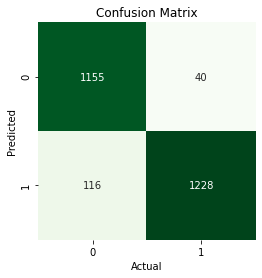

Accuracy: 0.94
Senstivity: 0.97
Specificity: 0.91


In [30]:
print('Best Parameters: {}'.format(nnc6.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc6.best_score_))

pred_nnc6 = nnc6.predict(X_test)

# plot_roc_curve(nnc6, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc6 = confusion_matrix(c_test, pred_nnc6)
tn, fp, fn, tp = cm_nnc6.ravel()

ax = sns.heatmap(cm_nnc6.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc6)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

In [31]:
# def final_model():
#     model = Sequential()
#     model.add(Input(shape=(40, )))
#     model.add(Dense(neurons = 15, activation = 'relu', kernel_constraint = maxnorm(3)))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation = 'sigmoid'))
#     optimizer = SGD(lr = 0.1, momentum = 0.1)
#     model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
#     return model
# annc_model = KerasClassifier(build_fn = final_model, batch_size = 10, epochs = 100, verbose = 0)